### Esercitazione 28 - Operare su più Timeframe

In [1]:
import MetaTrader5 as mt5
import pandas as pd
import talib
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta

In [2]:
connected = mt5.initialize(login=5798528, server="ActivTrades-Server", password='QFPHrdgg')

giorni_simulazione = 365 * 2
simbolo = 'BTCUSD'

if connected:
    candles_h4 = pd.DataFrame(mt5.copy_rates_from_pos(simbolo, mt5.TIMEFRAME_H4, 0, giorni_simulazione * 6))
    candles_h4['time'] = pd.to_datetime(candles_h4['time'], unit='s')
    candles_h4.set_index('time', inplace=True)

    candles_h1 = pd.DataFrame(mt5.copy_rates_from_pos(simbolo, mt5.TIMEFRAME_H1, 0, giorni_simulazione * 24))
    candles_h1['time'] = pd.to_datetime(candles_h1['time'], unit='s')
    candles_h1.set_index('time', inplace=True)

    candles_m15 = pd.DataFrame(mt5.copy_rates_from_pos(simbolo, mt5.TIMEFRAME_M15, 0, giorni_simulazione * 24 * 4))
    candles_m15['time'] = pd.to_datetime(candles_m15['time'], unit='s')
    candles_m15.set_index('time', inplace=True)

    mt5.shutdown()
else:
    print('MT5 account error.')

In [3]:
def get_tech_analysis(df):
    df['rsi'] = talib.RSI(df.close)
    df['rsi_1'] = df['rsi'].shift(1)
    df['sma_slow'] = talib.SMA(df.close, timeperiod=56)
    df['sma_slow_1'] = df['sma_slow'].shift(1)
    df['sma_fast'] = talib.SMA(df.close, timeperiod=14)
    df['sma_fast_1'] = df['sma_fast'].shift(1)
    df = df.iloc[57:]
    return df

candles_h4 = get_tech_analysis(candles_h4)
candles_h1 = get_tech_analysis(candles_h1)
candles_m15 = get_tech_analysis(candles_m15)

data_iniziale = max(candles_h4.index[0], candles_h1.index[0], candles_m15.index[0])

candles_h4 = candles_h4.loc[data_iniziale:]
candles_h1 = candles_h1.loc[data_iniziale:]
candles_m15 = candles_m15.loc[data_iniziale:]

In [4]:
soglia_rsi_low = 25
soglia_rsi_high = 75

operazioni = []

posizione = 0
for h4_idx, h4_candle in candles_h4.iterrows():
    if posizione == 0:
        if h4_candle.rsi < h4_candle.rsi_1 and h4_candle.rsi < soglia_rsi_low:
            for h1_idx, h1_candle in candles_h1.loc[h4_idx:h4_idx + timedelta(hours=4)].iterrows():
                if h1_candle.rsi < soglia_rsi_low:
                    for m15_idx, m15_candle in candles_m15.loc[h1_idx:h1_idx + timedelta(hours=1)].iterrows():
                        if m15_candle.rsi < soglia_rsi_low:
                            posizione = -1
                            break
                if posizione == -1:
                    break
            if posizione == -1:
                operazioni.append([m15_idx, m15_candle.close, np.nan, np.nan, -1])
        if h4_candle.rsi > h4_candle.rsi_1 and h4_candle.rsi > soglia_rsi_high:
            for h1_idx, h1_candle in candles_h1.loc[h4_idx:h4_idx + timedelta(hours=4)].iterrows():
                if h1_candle.rsi > soglia_rsi_high:
                    for m15_idx, m15_candle in candles_m15.loc[h1_idx:h1_idx + timedelta(hours=1)].iterrows():
                        if m15_candle.rsi > soglia_rsi_high:
                            posizione = 1
                            break
                if posizione == 1:
                    break
            if posizione == 1:
                operazioni.append([m15_idx, m15_candle.close, np.nan, np.nan, 1])
    elif posizione == -1:
        if h4_candle.rsi > h4_candle.rsi_1 and h4_candle.rsi > soglia_rsi_high - 25:
            for h1_idx, h1_candle in candles_h1.loc[h4_idx:h4_idx + timedelta(hours=4)].iterrows():
                if h1_candle.rsi > soglia_rsi_high - 25:
                    for m15_idx, m15_candle in candles_m15.loc[h1_idx:h1_idx + timedelta(hours=1)].iterrows():
                        if m15_candle.rsi > soglia_rsi_high - 25:
                            posizione = 0
                            break
                if posizione == 0:
                    break
            if posizione == 0:
                operazioni[-1][2] = m15_idx
                operazioni[-1][3] = m15_candle.close
    elif posizione == 1:
        if h4_candle.rsi < h4_candle.rsi_1 and h4_candle.rsi < soglia_rsi_low + 25:
            for h1_idx, h1_candle in candles_h1.loc[h4_idx:h4_idx + timedelta(hours=4)].iterrows():
                if h1_candle.rsi < soglia_rsi_low + 25:
                    for m15_idx, m15_candle in candles_m15.loc[h1_idx:h1_idx + timedelta(hours=1)].iterrows():
                        if m15_candle.rsi < soglia_rsi_low + 25:
                            posizione = 0
                            break
                if posizione == 0:
                    break
            if posizione == 0:
                operazioni[-1][2] = m15_idx
                operazioni[-1][3] = m15_candle.close

if np.isnan(operazioni[-1][3]):
    operazioni[-1][2] = candles_m15.iloc[-1].name
    operazioni[-1][3] = candles_m15.iloc[-1].close

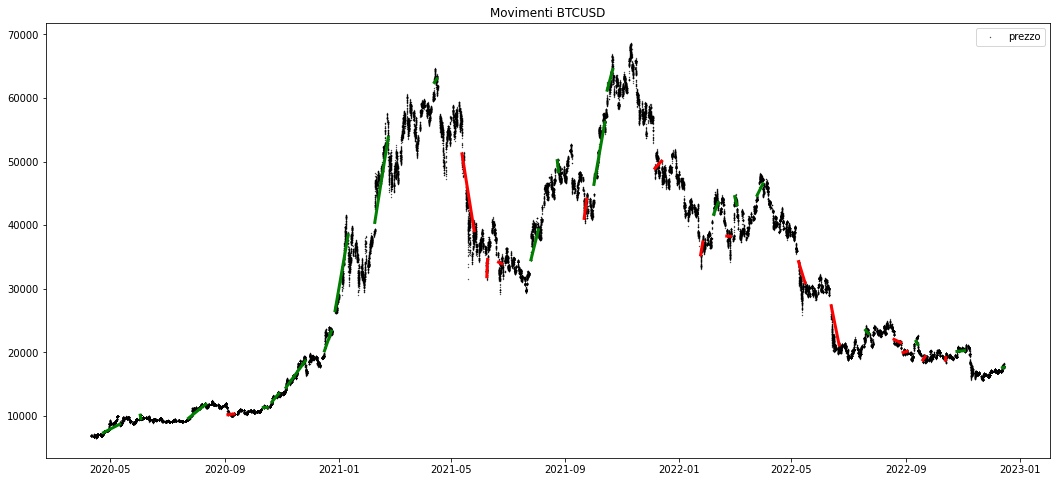

rendimento: 67416.23000000001 - vinte 22 / 35
max vincita: 13409.0
max perdita: -3033.199999999997


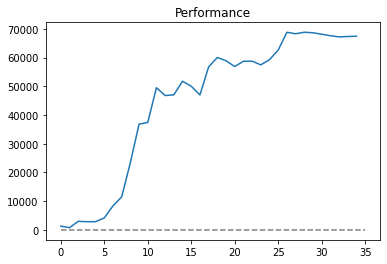

In [5]:
plt.figure(figsize=(18, 8))
plt.title('Movimenti ' + simbolo)
plt.scatter(candles_m15.index, candles_m15.close, label='prezzo', color='black', s=0.1)

rendimento = 0.
vinte = 0
giocate = 0
log_risultati = []
vincita_max = 0.
perdita_max = 0.

for op in operazioni:
    if op[4] == 1:
        plt.plot((op[0], op[2]), (op[1], op[3]), color='green', linewidth=3)
    else:
        plt.plot((op[0], op[2]), (op[1], op[3]), color='red', linewidth=3)
    risultato = (op[3] - op[1]) * op[4]
    rendimento += risultato
    if risultato > 0:
        vinte += 1
        if risultato > vincita_max:
            vincita_max = risultato
    elif risultato < perdita_max:
        perdita_max = risultato
    giocate += 1
    log_risultati.append(rendimento)
plt.legend()
plt.show()

print('rendimento:', rendimento, '- vinte', vinte, '/', giocate)
print('max vincita:', vincita_max)
print('max perdita:', perdita_max)

plt.plot(log_risultati)
plt.hlines(0, 0, len(log_risultati), colors='gray', linestyles='--')
plt.title('Performance')
plt.show()